In [26]:
#get the imports
import cv2
import matplotlib.pyplot as plt
#import glob
#import inspect
import random
import os
from sklearn.neighbors import KDTree
#import gc
from sklearn.cluster import KMeans
import pandas as pd
#import affinity
import multiprocessing as mp
import numpy as np
#affinity.set_process_affinity_mask(0,2**multiprocessing.cpu_count()-1)
#import warnings
#import psutil
#warnings.filterwarnings('ignore')
#os.system("taskset -p 0xfffff %d" % os.getpid())

In [27]:
#return keypoints from an image using SURF
def getSURFMatches(image,param):

    #use SURF to get set of keypoints and corresponding descriptors
    sift = cv2.xfeatures2d.SURF_create(param)
    kp1,des1 = sift.detectAndCompute(image,None)
    return kp1,des1

#returns set of keypoints from the set of images provided
def getRefSet(imageSet,param):
    
    pointsSet = []
    for img in imageSet:
        p,d = getSURFMatches(img,param)
        pointsSet += [d]
    return pointsSet

#returns a set of images present in a folder
def getImageSet(foldername):
    images = [cv2.imread(foldername + str(i)) for i in os.listdir(foldername)]
    return images

#computes the set of points in a query image that are less than an average distance from 
#the set of reference points
def getBestPoints(rpset,qpset):
    
    dists = []
    for q in qpset:
        sumn = np.sum(np.linalg.norm(rpset - q))
        dists += [sumn]
    
    avg = sum(dists)/len(dists)
    points = []
    for i,d in enumerate(dists):
        if d < avg:
            points += [qpset[i]]
            
    return points

#computes the set of stable points for as set of images using n-1 cross validation methods
def createTestSet(imageSet,param):
    
    #get total set of SURF points for all images
    totalPset = getRefSet(imageSet,param)
    tsetPoints = []
    for i,qpset in enumerate(totalPset):
        #reference set
        rpset = np.concatenate(totalPset[0:i] + totalPset[i+1:])
        tsetPoints += [getBestPoints(rpset,qpset)]
        
    return np.concatenate(tsetPoints)
        

In [28]:
#computes the set of stable points for as set of images using n-1 cross validation methods
def createTestSet_Kmean(imageSet,param):
    
    #get total set of SURF points for all images
    totalPset = getRefSet(imageSet,param)
    tsetPoints = []
    rpset = np.concatenate(totalPset)
        
    return rpset

def get_Kmean(data,clusters = 100):
    estimator = KMeans(init='k-means++', n_clusters=clusters, n_init=10)
    y = estimator.fit(data)
    return y

def get_variance(data,clusters = 100):
    var = []
    for i in range(clusters):
        temp = data[data.iloc[:,-1]==i]
        mean = pd.DataFrame.mean(temp)
        var.append(np.mean((np.array(temp) - np.array(mean))**2))
    var = np.array(var)
    mean_var = np.mean(var)
    a = np.where(var < mean_var,1,0)
    var = var[a]
    ind = np.nonzero(a)
#     return np.array(var).argsort()[:int(clusters/2)]
    return var,ind

In [29]:
#test set using kmeans algorithm
def kmeansRefPoints(imageSet,clusters=100):
    test_set = createTestSet_Kmean(imageSet,400)
    y = get_Kmean(test_set,clusters)
    cluster_centers = y.cluster_centers_
    data = pd.DataFrame(test_set)
    Y = pd.DataFrame(y.labels_)
    #print (data.shape,Y.shape)
    data = data.join(Y,how='left', lsuffix='_left', rsuffix='_right')

    var,indexes = get_variance(data,clusters)

    a = (np.isin(np.array(data)[:,-1], indexes))
    ref_set = np.array(data)[a]
    ref_set = ref_set[:,:-1]
    cluster_centers = cluster_centers[indexes]
    return ref_set,cluster_centers[indexes]

In [30]:
"""
Code for getting the stable points in an image (good points)

The algorithm is a nearest neighbour classification where each 
query point is compared with k nearest stable points. The distances 
are averaged and the resuting query point is termed as a good point 
if it lies within a threshold parameter.

The parameters to the system are :
theta : threshold to determine if the point is stable based on distances
K : the number of closest points to check (1 according to the paper)
refSet : the set of reference stable points represented as a KD-Tree 
param : Input to SURF to detect keypoints (400 acccording to the paper)

The function return the average distance of the closest k points 
averaged over the entire query set of points, the percentage of good points,
the number of good points and the total number of query points.
They are collectively henceforth referred to as the 'stats' for each invocation 
with a given set of params(theta value and k value).
"""

def get_good_points(image,theta,refSet,k=1,param=400):
    
    ds = None
    if param is not None:
        kp,ds = getSURFMatches(image,param)
    else:
        ds = image
    good = 0
    kAvgDist = 0
    for q in ds:
        dist,ind = refSet.query(q.reshape(1,-1),k)
        #print(dist)
        avgDist = sum(dist[0])/k
        #print(avgDist)
        kAvgDist += avgDist
        if avgDist < theta:
            good += 1
    
    return [kAvgDist/ds.shape[0]],good/ds.shape[0],good,ds.shape[0]


In [49]:
#return the stats for a set fo images based on the params, 
#the last two params can be used for multithreded invocations and are not used here
def imageStats(imageSet,theta,refSet,k=1,param=400):
    

    stats = []
    for i in imageSet:
        if param is not None:
            image = cv2.imread(i)
        else:
            image = i
        res = get_good_points(image,theta,refSet,k,param)
        stats += [[res[0][0],res[1],res[2],res[3]]]
    

    return stats

In [32]:
#gets the stats for a range for threshold values 
def getStatsRangeTheta(imageSet,tStart,tEnd,tStep,refSet,k,param):
    
    total = int(round((tEnd - tStart)/tStep))
    tht = [tStart + i*tStep for i in range(total)]
    Pools = mp.Pool(mp.cpu_count())
    #print(mp.cpu_count())
    args = [(imageSet,theta,refSet,k,param) for theta in tht]
    #print(args)
    res = Pools.starmap(imageStats,args)
    #Pools.close()
    #Pools.join()
    return tht,res


In [91]:
def trainSetPredictions(images,imageType,thts,p_threshold=0.75):
    
    lbls = np.unique(imageType)
    res = []  
    #print(images)
    for it,th in enumerate(thts):
        d = {}
        for l in lbls:
            
            temp = images[it][np.where(imageType == l)[0],1]
            
            true = np.sum(temp >= p_threshold)
            fals = temp.shape[0] - true
            d[l] = (true,fals)
        res += [(round(th,4),d)]
        
    return res

def predictions(images,imageType,p_threshold=0.75):
    
    lbls = np.unique(imageType)  
    d = {}
    for l in lbls:
        temp = images[np.where(imageType == l)[0],1]
        true = np.sum(temp >= p_threshold)
        fals = temp.shape[0] - true
        d[l] = (true,fals)
    return d


In [70]:
def getBesttheta(results,truelabel):
    
    #x,y = [],[]
    minerr = 100
    mintht = None
    for r in results:
        tp,tn,fp,fn = 0,0,0,0
        for k in r[1].keys():
            if k == truelabel:
                tp,fn = r[1][k][0],r[1][k][1]
            else:
                fp += r[1][k][0]
                tn += r[1][k][1]
        x = tp/(tp + fn)
        y = fp/(tn + fp)
        if abs((1-x) - y) < minerr:
            minerr = abs((1-x) - y)
            mintht = (r,x,y)
            
    return mintht
    

In [35]:
def rocPlot(results,trueLabel):
    
    x,y = [],[]
    for r in results:
        print("Threshold",r[0])
        print(r[1])
        tp,tn,fp,fn = 0,0,0,0
        for k in r[1].keys():
            if k == trueLabel:
                tp,fn = r[1][k][0],r[1][k][1]
            else:
                fp += r[1][k][0]
                tn += r[1][k][1]
        print("TRP",tp/(tp + fn),"FPR",fp/(tn + fp))
        print("------------------------------------")
        x += [tp/(tp + fn)]
        y += [fp/(tn + fp)]
        
    plt.figure(figsize=(10,8))
    plt.plot(y,x)
    plt.ylabel("True Positive Rate")
    plt.xlabel('False Positive Rate')
    plt.title("ROC curve for threshold range " + str(results[0][0]) + " - " + str(results[-1][0]) + " inclusive")
    plt.show()

In [12]:
#get image set in location form
genImage = ['./signatures/full_org/' + str(image) for image in \
                sorted(os.listdir("./signatures/full_org/"))]
forgImage = ['./signatures/full_forg/' + str(image) for image in \
                sorted(os.listdir("./signatures/full_forg/"))]

In [ ]:
#get image in array form
genImage = [cv2.imread('./signatures/full_org/' + str(image)) for image in \
                sorted(os.listdir("./signatures/full_org/"))]
forgImage = [cv2.imread('./signatures/full_forg/' + str(image)) for image in \
                sorted(os.listdir("./signatures/full_forg/"))]

In [19]:
#image as surf points
param = 400
genImage = [getSURFMatches(cv2.imread('./signatures/full_org/' + str(image)),param)[1] for image in \
                sorted(os.listdir("./signatures/full_org/"))]
forgImage = [getSURFMatches(cv2.imread('./signatures/full_forg/' + str(image)),param)[1] for image in \
                sorted(os.listdir("./signatures/full_forg/"))]
pgenImage = genImage
pforgImage = forgImage

In [20]:
genImage = np.array(genImage)
genImage = genImage.reshape(-1,24)
forgImage = np.array(forgImage)
forgImage = forgImage.reshape(-1,24)

In [38]:
#reference set images
rsetImage = np.array([cv2.imread('./signatures/full_org/' + str(image)) for image in \
                sorted(os.listdir("./signatures/full_org/"))]).reshape(-1,24)
#refSet = [cv2.imread(image[0]) for image in rsetImage.reshape(-1,1)]

## Testing using all images

In [ ]:
refSet = [cv2.imread(image[0]) for image in rsetImage[:,:4].reshape(-1,1)]
trainSet = [image[0] for image in np.hstack((genImage[:,4:20],forgImage[:,:20])).reshape(-1,1)]
trainSetLabel = np.hstack((np.ones([genImage.shape[0],16]),np.zeros([forgImage.shape[0],20]))).reshape(-1,1)
testSet = [image for image in np.hstack((genImage[:,20:],forgImage[:,20:])).reshape(-1,1)]
testSetLabel = np.hstack((np.ones([genImage.shape[0],4]),np.zeros([forgImage.shape[0],4]))).reshape(-1,1)

In [ ]:
normalPoints = createTestSet(refSet,400)
kdnormalPoints = KDTree(normalPoints,leaf_size=40)

In [ ]:
tht,results = getStatsRangeTheta(trainSet,0.14,0.22,0.01,kdnormalPoints,k=4,param=None)
results = np.array(results)
pred = trainSetPredictions(results,trainSetLabel,tht,p_threshold=0.50)

Threshold 0.14
{0.0: (302, 798), 1.0: (190, 690)}
TRP 0.2159090909090909 FPR 0.27454545454545454
------------------------------------
Threshold 0.15
{0.0: (410, 690), 1.0: (247, 633)}
TRP 0.2806818181818182 FPR 0.37272727272727274
------------------------------------
Threshold 0.16
{0.0: (509, 591), 1.0: (315, 565)}
TRP 0.35795454545454547 FPR 0.4627272727272727
------------------------------------
Threshold 0.17
{0.0: (614, 486), 1.0: (403, 477)}
TRP 0.45795454545454545 FPR 0.5581818181818182
------------------------------------
Threshold 0.18
{0.0: (705, 395), 1.0: (497, 383)}
TRP 0.5647727272727273 FPR 0.6409090909090909
------------------------------------
Threshold 0.19
{0.0: (795, 305), 1.0: (603, 277)}
TRP 0.6852272727272727 FPR 0.7227272727272728
------------------------------------
Threshold 0.2
{0.0: (866, 234), 1.0: (703, 177)}
TRP 0.7988636363636363 FPR 0.7872727272727272
------------------------------------
Threshold 0.21
{0.0: (952, 148), 1.0: (773, 107)}
TRP 0.8784090909

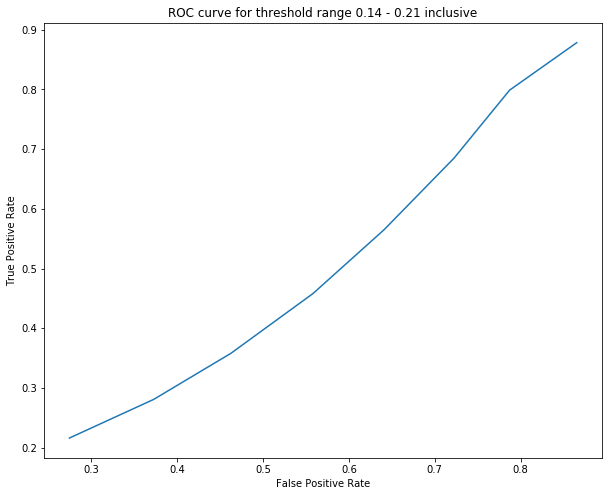

In [180]:
rocPlot(pred,1)

In [ ]:
tht2,results2 = getStatsRangeTheta(trainSet,0.14,0.29,0.01,kdnormalPoints,k=1,param=None)
results = np.array(results2)

In [183]:
pred = trainSetPredictions(results,trainSetLabel,tht2,p_threshold=0.50)

Threshold 0.14
{0.0: (442, 658), 1.0: (276, 604)}
TRP 0.31363636363636366 FPR 0.4018181818181818
------------------------------------
Threshold 0.15
{0.0: (539, 561), 1.0: (355, 525)}
TRP 0.4034090909090909 FPR 0.49
------------------------------------
Threshold 0.16
{0.0: (652, 448), 1.0: (450, 430)}
TRP 0.5113636363636364 FPR 0.5927272727272728
------------------------------------
Threshold 0.17
{0.0: (754, 346), 1.0: (566, 314)}
TRP 0.6431818181818182 FPR 0.6854545454545454
------------------------------------
Threshold 0.18
{0.0: (816, 284), 1.0: (662, 218)}
TRP 0.7522727272727273 FPR 0.7418181818181818
------------------------------------
Threshold 0.19
{0.0: (911, 189), 1.0: (747, 133)}
TRP 0.8488636363636364 FPR 0.8281818181818181
------------------------------------
Threshold 0.2
{0.0: (986, 114), 1.0: (811, 69)}
TRP 0.9215909090909091 FPR 0.8963636363636364
------------------------------------
Threshold 0.21
{0.0: (1048, 52), 1.0: (853, 27)}
TRP 0.9693181818181819 FPR 0.952727

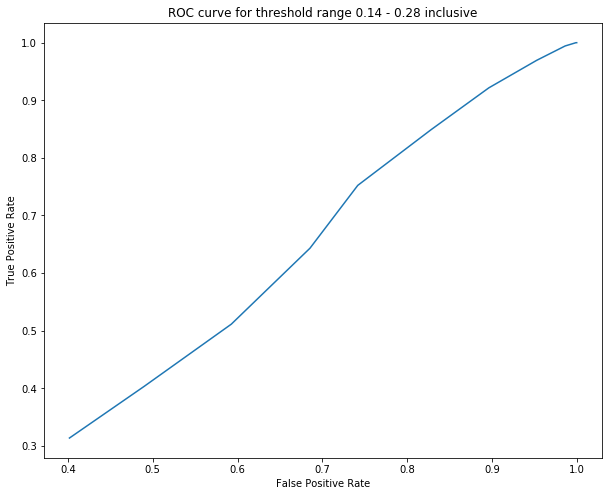

In [184]:
rocPlot(pred,1)

## Getting theta values for authors one by one

In [102]:
def trainTestTheta(gdata,fdata,rdata,split,tStart,tEnd,tStep,k=1,p=0.75):
    refSetPoints = KDTree(createTestSet(rdata,400),leaf_size=40)
    
    train = np.hstack((gdata[:split],fdata[:split]))
    trainLabel = np.hstack((np.ones([gdata[:split].shape[0]]),np.zeros([fdata[:split].shape[0]])))
    
    test = np.hstack((gdata[split:],fdata[split:]))
    testLabel = np.hstack((np.ones([gdata[split:].shape[0]]),np.zeros([fdata[split:].shape[0]])))
    
    tht,res = getStatsRangeTheta(train,tStart,tEnd,tStep,refSetPoints,k,None)
    res = np.array(res)
    pred = trainSetPredictions(res,trainLabel,tht,p_threshold=p)
    res = getBesttheta(pred,1)
    #print(res)
    print("Training Results")
    print("Best Threshold",res[0][0],"Genuine Prediction(T,F)",res[0][1][1],"False Predictions(T,F)",res[0][1][0], \
          "TPR",res[1],"FPR",res[2])
    print("Tests Results")
    
    testRes = np.array(imageStats(test,res[0][0],refSetPoints,k,None))
    p = predictions(testRes,testLabel,p)
    print("Genuine Prediction(T,F)",p[1],"False Predictions(T,F)",p[0], \
          "TPR",p[1][0]/(p[1][0] + p[1][1]),"FPR",p[0][0]/(p[0][0] + p[0][1]))
    
    

In [105]:
genSplit = 6
split = 12
for i in range(genImage.shape[0]):
    #refSet = KDTree(createTestSet(rsetImage[i,:genSplit],400))
    print("----------------------\nGetting ROC curve for ",i)
    trainTestTheta(genImage[i,genSplit:],forgImage[i,:],rsetImage[i,:genSplit],10,0.14,0.26,0.005,k=1,p=0.50)

----------------------
Getting ROC curve for  0
Training Results
Best Threshold 0.155 Genuine Prediction(T,F) (3, 7) False Predictions(T,F) (6, 4) TPR 0.3 FPR 0.6
Tests Results
Genuine Prediction(T,F) (1, 7) False Predictions(T,F) (5, 9) TPR 0.125 FPR 0.35714285714285715
----------------------
Getting ROC curve for  1
Training Results
Best Threshold 0.215 Genuine Prediction(T,F) (3, 7) False Predictions(T,F) (7, 3) TPR 0.3 FPR 0.7
Tests Results
Genuine Prediction(T,F) (4, 4) False Predictions(T,F) (9, 5) TPR 0.5 FPR 0.6428571428571429
----------------------
Getting ROC curve for  2
Training Results
Best Threshold 0.18 Genuine Prediction(T,F) (6, 4) False Predictions(T,F) (5, 5) TPR 0.6 FPR 0.5
Tests Results
Genuine Prediction(T,F) (7, 1) False Predictions(T,F) (6, 8) TPR 0.875 FPR 0.42857142857142855
----------------------
Getting ROC curve for  3
Training Results
Best Threshold 0.205 Genuine Prediction(T,F) (8, 2) False Predictions(T,F) (1, 9) TPR 0.8 FPR 0.1
Tests Results
Genuine Pre

Genuine Prediction(T,F) (8, 0) False Predictions(T,F) (0, 14) TPR 1.0 FPR 0.0
----------------------
Getting ROC curve for  31
Training Results
Best Threshold 0.155 Genuine Prediction(T,F) (9, 1) False Predictions(T,F) (1, 9) TPR 0.9 FPR 0.1
Tests Results
Genuine Prediction(T,F) (4, 4) False Predictions(T,F) (2, 12) TPR 0.5 FPR 0.14285714285714285
----------------------
Getting ROC curve for  32
Training Results
Best Threshold 0.2 Genuine Prediction(T,F) (6, 4) False Predictions(T,F) (3, 7) TPR 0.6 FPR 0.3
Tests Results
Genuine Prediction(T,F) (3, 5) False Predictions(T,F) (2, 12) TPR 0.375 FPR 0.14285714285714285
----------------------
Getting ROC curve for  33
Training Results
Best Threshold 0.16 Genuine Prediction(T,F) (10, 0) False Predictions(T,F) (0, 10) TPR 1.0 FPR 0.0
Tests Results
Genuine Prediction(T,F) (8, 0) False Predictions(T,F) (0, 14) TPR 1.0 FPR 0.0
----------------------
Getting ROC curve for  34
Training Results
Best Threshold 0.21 Genuine Prediction(T,F) (8, 2) Fals